 **importando el dataset y descomprimiendolo. Ademas de importar las librerias 
necesarias**

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c state-farm-distracted-driver-detection

Saving kaggle.json to kaggle.json
 99% 3.98G/4.00G [00:34<00:00, 134MB/s]
100% 4.00G/4.00G [00:34<00:00, 124MB/s]


In [2]:
# Descomprimiendo ek dataset
import zipfile

with zipfile.ZipFile('/content/state-farm-distracted-driver-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/conductores')

In [1]:
from PIL import Image
from skimage import io
from skimage.transform import resize
import albumentations as A
from scipy.io import loadmat

import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

Dividiendo en datos de prueba y entrenamiento

In [2]:
dataset = pd.read_csv('/content/conductores/driver_imgs_list.csv')
by_drivers = dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()

In [3]:
NUMBER_CLASSES = 10

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('\nCargando directorio c{}'.format(classed))
        files = glob(os.path.join('conductores', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Datos cargados en {} segundos".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('conductores', 'imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)    
    return test_data, test_ids

In [4]:
img_rows = 64
img_cols = 64
color_type = 1

In [5]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print(x_train.shape)
print(x_train.shape[0], 'imagenes de entrenamiento')

  0%|          | 0/10 [00:00<?, ?it/s]


Cargando directorio c0


 10%|█         | 1/10 [00:11<01:46, 11.80s/it]


Cargando directorio c1


 20%|██        | 2/10 [00:20<01:17,  9.69s/it]


Cargando directorio c2


 30%|███       | 3/10 [00:24<00:50,  7.27s/it]


Cargando directorio c3


 40%|████      | 4/10 [00:28<00:35,  5.99s/it]


Cargando directorio c4


 50%|█████     | 5/10 [00:32<00:26,  5.26s/it]


Cargando directorio c5


 60%|██████    | 6/10 [00:36<00:19,  4.84s/it]


Cargando directorio c6


 70%|███████   | 7/10 [00:40<00:13,  4.56s/it]


Cargando directorio c7


 80%|████████  | 8/10 [00:43<00:08,  4.22s/it]


Cargando directorio c8


 90%|█████████ | 9/10 [00:47<00:03,  3.93s/it]


Cargando directorio c9


100%|██████████| 10/10 [00:50<00:00,  5.08s/it]

Datos cargados en 50.84920525550842 segundos
(17939, 64, 64, 1)
17939 imagenes de entrenamiento


In [6]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print(test_files.shape)
print(test_files.shape[0], 'imagenes de test')

  0%|          | 200/79726 [00:00<02:26, 544.41it/s]

(200, 64, 64, 1)
200 imagenes de test


Estadísticas

In [7]:
names = [item[17:19] for item in sorted(glob("/content/conductores/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('/content/conductores/imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('Existen %s imagenes.\n' % (test_files_size + x_train_size + x_test_size))
print('Existen %d imagenes de entrenamiento.' % x_train_size)
print('Existen %d categorías totales de entrenamiento' % categories_size)
print('Existen %d imágenes de validación' % x_test_size)
print('Existen %d imágenes de prueba.'% test_files_size)

Existen 102150 imagenes.

Existen 17939 imagenes de entrenamiento.
Existen 10 categorías totales de entrenamiento
Existen 4485 imágenes de validación
Existen 79726 imágenes de prueba.


Visualizacion de datos

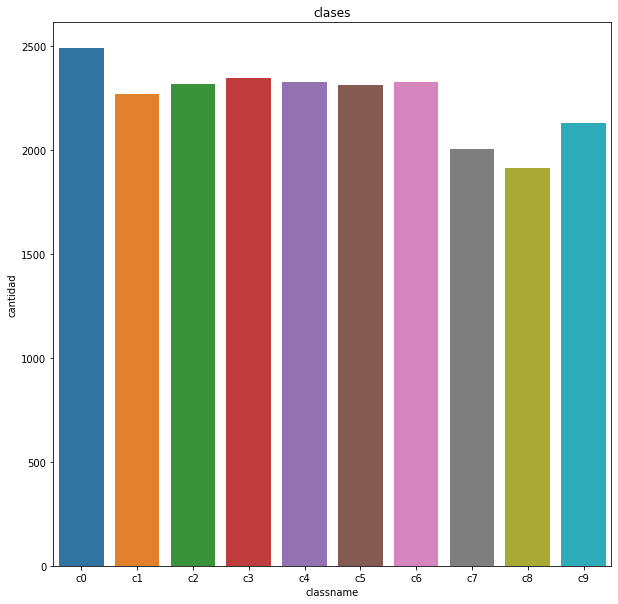

In [12]:
plt.figure(figsize = (10,10))
sns.countplot(x = 'classname', data = dataset)
plt.ylabel('cantidad')
plt.title('clases')
plt.show()

In [13]:
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']

Imagenes

In [14]:
activity_map = {'c0': 'Conducción segura', 
                'c1': 'Mensajes de texto - derecha', 
                'c2': 'Hablar por teléfono - derecha', 
                'c3': 'Mensajes de texto - izquierda', 
                'c4': 'Hablar por teléfono - izquierda', 
                'c5': 'Funcionamiento de la radio', 
                'c6': 'bebiendo', 
                'c7': 'Llegar detrás', 
                'c8': 'Tocandode el cabello', 
                'c9': 'Hablando con el pasajero'}

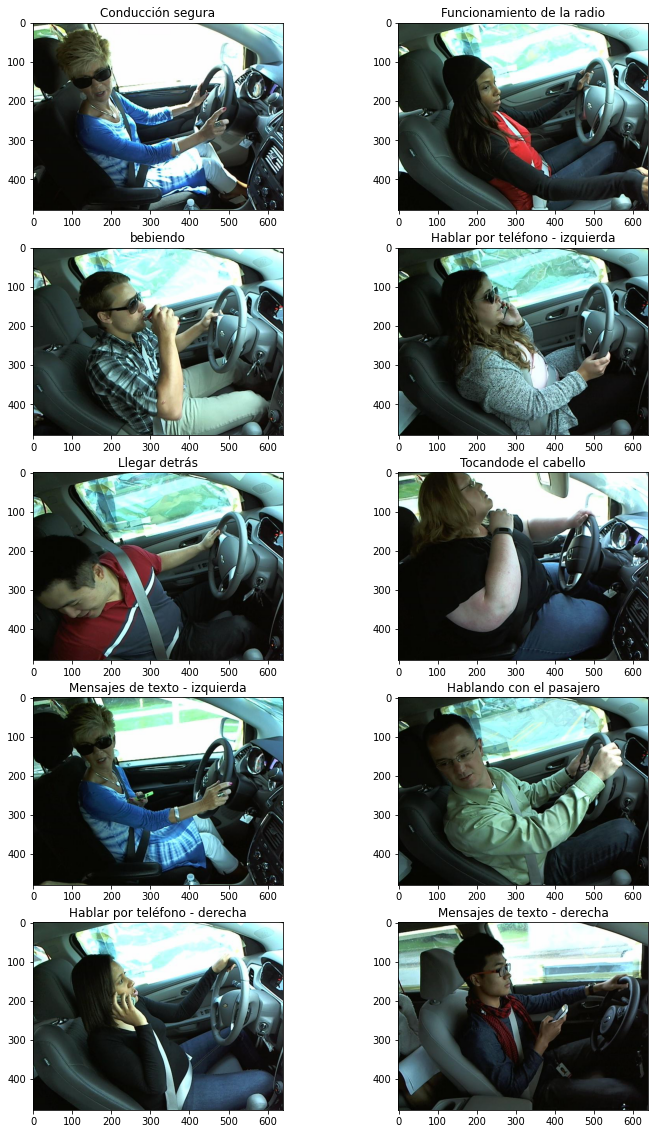

In [15]:
plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '/content/conductores/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [17]:
def plot_train_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy del modelo')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdidda del modelo')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Prediccion de Y: {}'.format(y_prediction))
    print('Predijo: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

Construyendo el modelo

In [16]:
batch_size = 40
nb_epoch = 10

Entrena una CNN con Transfer Learning

In [18]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    nb_classes = 10
    vgg16_model = VGG16(weights="imagenet", include_top=False)
    
    for layer in vgg16_model.layers:
        layer.trainable = False
        
    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)

    predictions = Dense(nb_classes, activation = 'softmax')(x)
    model = Model(inputs = vgg16_model.input, outputs  = predictions)
    
    return model 

In [ ]:
print("Cargando red...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()
model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

data aumentation

In [20]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)


training_generator = train_datagen.flow_from_directory('/content/conductores/imgs/train', 
                                                 target_size = (img_rows, img_cols), 
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('/content/conductores/imgs/train', 
                                                   target_size = (img_rows, img_cols), 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [22]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpoint = ModelCheckpoint(filepath='saved_models/weights_best_vgg16.h5', 
                             monitor='val_accuracy', mode='max',
                             verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = [checkpoint, es]

In [25]:
history_v4 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 25, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size
                         )

Epoch 1/25
448/448 [==============================] - ETA: 0s - loss: 1.5657 - accuracy: 0.4456
Epoch 1: val_accuracy improved from -inf to 0.55089, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 120s 268ms/step - loss: 1.5657 - accuracy: 0.4456 - val_loss: 1.2180 - val_accuracy: 0.5509
Epoch 2/25
448/448 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.5979
Epoch 2: val_accuracy improved from 0.55089 to 0.66496, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 116s 258ms/step - loss: 1.1482 - accuracy: 0.5979 - val_loss: 0.9510 - val_accuracy: 0.6650
Epoch 3/25
448/448 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6682
Epoch 3: val_accuracy improved from 0.66496 to 0.75781, saving model to saved_models/weights_best_vgg16.h5
448/448 [==============================] - 112s 249ms/step - loss: 0.9607 - accuracy: 0.6682 - val_loss: 0.7111 - val_accura

guardando modelo 

In [ ]:
model_vgg16.save('conductores.h5')  

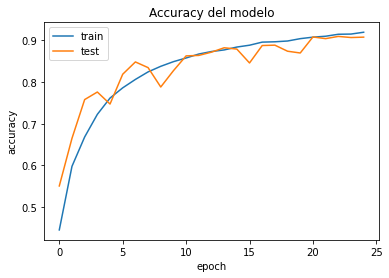

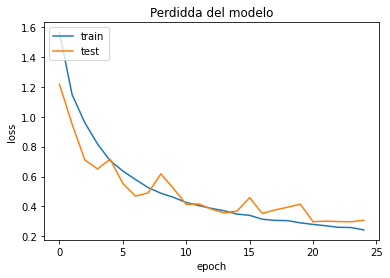

In [26]:
plot_train_history(history_v4)

In [27]:
def plot_vgg16_test_class(model, test_files, image_number):
    img_brute = test_files[image_number]

    im = cv2.resize(cv2.cvtColor(img_brute, cv2.COLOR_BGR2RGB), (img_rows,img_cols)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    img_display = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_display, cmap='gray')

    y_preds = model.predict(im, batch_size=batch_size, verbose=1)
    print(y_preds)
    y_prediction = np.argmax(y_preds)
    print('Y Prediction: {}'.format(y_prediction))
    print('Predicted as: {}'.format(activity_map.get('c{}'.format(y_prediction))))
    
    plt.show()

1/1 [==============================] - 0s 497ms/step
[[6.19337588e-05 1.00262435e-02 6.18059576e-01 2.82876283e-01
  2.56532822e-02 1.00068031e-02 4.81360182e-02 7.36390066e-04
  2.01558857e-03 2.42786249e-03]]
Y Prediction: 2
Predicted as: Hablar por teléfono - derecha


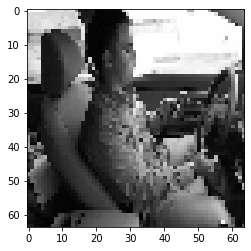

In [28]:
plot_vgg16_test_class(model_vgg16, test_files, 133) 

1/1 [==============================] - 0s 18ms/step
[[1.16513055e-02 1.77629830e-04 1.13496173e-03 2.12508142e-02
  4.32301089e-02 4.79990547e-07 3.77028955e-05 4.73969834e-07
  9.22470936e-04 9.21593964e-01]]
Y Prediction: 9
Predicted as: Hablando con el pasajero


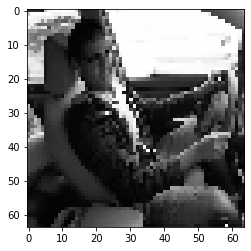

In [29]:
plot_vgg16_test_class(model_vgg16, test_files, 29) 

1/1 [==============================] - 0s 22ms/step
[[3.9962069e-03 3.1564078e-08 1.0983009e-07 1.2335375e-08 3.5736684e-04
  3.2064755e-02 1.7565176e-02 2.5937064e-07 9.3922836e-01 6.7877746e-03]]
Y Prediction: 8
Predicted as: Tocandode el cabello


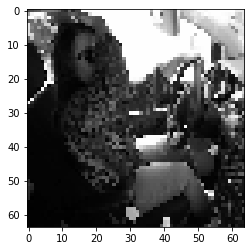

In [30]:
plot_vgg16_test_class(model_vgg16, test_files, 82) 

In [31]:
score = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

112/112 [==============================] - 19s 171ms/step - loss: 0.3069 - accuracy: 0.9074
Test Score: 0.30688798427581787
Test Accuracy: 0.9073660969734192


--------------------------------------

Otras pruebas, ejecutar en colab

----------------------


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [ ]:
take_photo()

<IPython.core.display.Javascript object>

*******************


In [ ]:
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
 
# start streaming video from webcam
take_photo()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      display(js)
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
      }
      ''')

  
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_stream()